# Yelp Reviews for Senti-Analysis Binary-N/P+

In [1]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

mkdir: cannot create directory ‘/u/joshisri/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/u/joshisri/.kaggle/kaggle.json': No such file or directory


In [2]:
! kaggle datasets download -d yacharki/yelp-reviews-for-sentianalysis-binary-np-csv
!pip3 install scipy

/bin/bash: kaggle: command not found


#### **Importing Libraries**

In [1]:
CUDA_LAUNCH_BLOCKING=1
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import preprocessing,tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

downloading the datasets

In [2]:
!unzip /content/yelp-reviews-for-sentianalysis-binary-np-csv.zip

unzip:  cannot find or open /content/yelp-reviews-for-sentianalysis-binary-np-csv.zip, /content/yelp-reviews-for-sentianalysis-binary-np-csv.zip.zip or /content/yelp-reviews-for-sentianalysis-binary-np-csv.zip.ZIP.


In [3]:
yelp_train_data = pd.read_csv('train.csv')
yelp_test_data = pd.read_csv('test.csv')

# import csv
# yelp_train_data = pd.read_csv('train.csv', delimiter=",", quoting=csv.QUOTE_NONE, encoding='utf-8')
# yelp_test_data = pd.read_csv('test.csv', delimiter=",", quoting=csv.QUOTE_NONE, encoding='utf-8')

In [4]:
print(yelp_train_data.shape)
print(yelp_test_data.shape)

(560000, 2)
(38000, 2)


#### **Data Description:**

- In total there are 560,000 training samples and 2 columns in them corresponding to **class index** (1 and 2) and **review text**. Negative polarity is class 1, and positive polarity is class 2.

- Also, we can see that there are 38000 testing samples.

In [5]:
#sample of training data
yelp_train_data.head()

,class_index,review_text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [6]:
#sample of testing data
yelp_test_data.head()

,class_index,review_text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


Below, we can see an example of a negative review 

In [7]:
yelp_train_data['review_text'][0]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

We can see that both the postive and negative classes are equally distributed in training and testing data.

In [8]:
yelp_train_data.class_index.value_counts()

1    280000
2    280000
Name: class_index, dtype: int64

In [9]:
yelp_test_data.class_index.value_counts()

2    19000
1    19000
Name: class_index, dtype: int64

#### **Text cleaning and Data Preprocessing** 

In [10]:
#cleaning the reviews
def cleaning_text(review):

    #removing the url's
    review = re.sub('http\S+\s*', ' ', review)
    #removing the  punctuations
    review = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>@[\]^_`{|}~"""), ' ', review)
    #removing non-ascii characters
    review = re.sub(r'[^\x00-\x7f]',r' ', review)
    #removing mentions (i.e, @)
    review = re.sub('@\S+', '  ', review)
    #removing hashtags
    review = re.sub('#\S+', ' ', review)
    #remove numbers
    review = re.sub("\d+", ' ', review)
    #removing extra whitespaces, wherever applicable
    review = re.sub('\s+', ' ',review)
    #converting the text into lowercase
    review = review.lower()

    return review

Here, we added a new column **clean_review_text** by cleaning the review_text(by removing punctuations, Url's, numbers, etc).

In [11]:
yelp_train_data['clean_review_text'] = yelp_train_data['review_text'].apply(cleaning_text)
yelp_test_data['clean_review_text'] = yelp_test_data['review_text'].apply(cleaning_text)

In [12]:
#train data after adding a new column with clean reviews
yelp_train_data.head()

,class_index,review_text,clean_review_text
0,1,"Unfortunately, the frustration of being Dr. Go...",unfortunately the frustration of being dr gold...
1,2,Been going to Dr. Goldberg for over 10 years. ...,been going to dr goldberg for over years i thi...
2,1,I don't know what Dr. Goldberg was like before...,i don t know what dr goldberg was like before ...
3,1,I'm writing this review to give you a heads up...,i m writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...,all the food is great here but the best thing ...


In [13]:
#test data after adding a new column with clean reviews
yelp_test_data.head()

,class_index,review_text,clean_review_text
0,2,"Contrary to other reviews, I have zero complai...",contrary to other reviews i have zero complain...
1,1,Last summer I had an appointment to get new ti...,last summer i had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an...",friendly staff same starbucks fair you get any...
3,1,The food is good. Unfortunately the service is...,the food is good unfortunately the service is ...
4,2,Even when we didn't have a car Filene's Baseme...,even when we didn t have a car filene s baseme...


**Feature Engineering:** Adding custom features

In [14]:
def custom_features(data):
    #number of words in each review
    data['no_of_words'] = data['clean_review_text'].apply(lambda x: len(str(x).split()))
    #average length of each word in each review
    data['avg_length_word'] = data['clean_review_text'].apply(lambda x: np.average([len(each_word) for each_word in str(x).split()]))
    #number of characters in each review
    data['no_of_characters'] = data['clean_review_text'].apply(lambda x: len(str(x)))
    #number of unique words in each review
    data['no_of_unique_words'] = data['clean_review_text'].apply(lambda x: len(set(str(x).split())))
    
    return data

In [15]:
yelp_train_data = custom_features(yelp_train_data)
yelp_test_data = custom_features(yelp_test_data)

/nfs/jolteon/data/hdd/sripad/sripad_vm_new/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


In [16]:
print(yelp_train_data.shape)
print(yelp_test_data.shape)

(560000, 7)
(38000, 7)


In [17]:
#train data after adding custom features
yelp_train_data.head()

,class_index,review_text,clean_review_text,no_of_words,avg_length_word,no_of_characters,no_of_unique_words
0,1,"Unfortunately, the frustration of being Dr. Go...",unfortunately the frustration of being dr gold...,118,4.237288,618,80
1,2,Been going to Dr. Goldberg for over 10 years. ...,been going to dr goldberg for over years i thi...,98,3.908163,481,71
2,1,I don't know what Dr. Goldberg was like before...,i don t know what dr goldberg was like before ...,213,4.234742,1115,132
3,1,I'm writing this review to give you a heads up...,i m writing this review to give you a heads up...,203,4.029557,1021,108
4,2,All the food is great here. But the best thing...,all the food is great here but the best thing ...,76,4.105263,388,53


In [18]:
#test data after adding custom features
yelp_test_data.head()

,class_index,review_text,clean_review_text,no_of_words,avg_length_word,no_of_characters,no_of_unique_words
0,2,"Contrary to other reviews, I have zero complai...",contrary to other reviews i have zero complain...,125,4.296000,662,91
1,1,Last summer I had an appointment to get new ti...,last summer i had an appointment to get new ti...,72,3.861111,350,55
2,2,"Friendly staff, same starbucks fair you get an...",friendly staff same starbucks fair you get any...,15,5.000000,90,14
3,1,The food is good. Unfortunately the service is...,the food is good unfortunately the service is ...,54,4.500000,297,42
4,2,Even when we didn't have a car Filene's Baseme...,even when we didn t have a car filene s baseme...,143,4.230769,748,86


In [19]:
#let's see which column/columns have null values
print(yelp_train_data.isnull().sum())
print(yelp_test_data.isnull().sum())

class_index            0
review_text            0
clean_review_text      0
no_of_words            0
avg_length_word       29
no_of_characters       0
no_of_unique_words     0
dtype: int64
class_index           0
review_text           0
clean_review_text     0
no_of_words           0
avg_length_word       0
no_of_characters      0
no_of_unique_words    0
dtype: int64


In [20]:
#From the above output, we can see that in the training data the column 'avg_length_word' has null values.
#So,removing the rows that contain null values
yelp_train_data = yelp_train_data.dropna()
yelp_train_data.shape

(559971, 7)

Partitioning the training and testing data and filtering the columns.


In [21]:
#creating a dataframe only for custom features
yelp_cf_train = yelp_train_data[['no_of_words','avg_length_word','no_of_characters','no_of_unique_words']]
yelp_cf_test = yelp_test_data[['no_of_words','avg_length_word','no_of_characters','no_of_unique_words']]
print(yelp_cf_train.shape)
print(yelp_cf_test.shape)

(559971, 4)
(38000, 4)


In [22]:
#target variables
y_train = yelp_train_data['class_index']
y_test = yelp_test_data['class_index']
print(y_train.shape)
print(y_test.shape)

(559971,)
(38000,)


#### **Count Vectorizer**

- Convert a collection of text documents to a matrix of token counts

In [23]:
def count_vect(train_data,test_data):

    #Initialising the countvectorizer
    #df:When building the vocabulary it ignores the terms that have a document frequency strictly lower than the given threshold(df=5)
    vectorizer = CountVectorizer(min_df=5)
    #fit_transform learns the vocabulary dictionary and return document-term matrix.
    train_cv = vectorizer.fit_transform(train_data)
    #Transform documents to document-term matrix
    test_cv = vectorizer.transform(test_data)

    return train_cv,test_cv

In [24]:
yelp_train_cv,yelp_test_cv=count_vect(yelp_train_data['clean_review_text'],yelp_test_data['clean_review_text'])

In [25]:
print(yelp_train_cv.shape)
print(yelp_test_cv.shape)

(559971, 61467)
(38000, 61467)


#### **TF-IDF Vectorizer**

- Convert a collection of raw documents to a matrix of TF-IDF features.

In [26]:
def tf_idf_vect(train_data,test_data):

    #Initialising the tf-idf vectorizer
    #df:When building the vocabulary it ignores the terms that have a document frequency strictly lower than the given threshold(df=5)
    vectorizer = TfidfVectorizer(min_df=5)
    #fit_transform learns the vocabulary dictionary and return document-term matrix.
    train_cv = vectorizer.fit_transform(train_data)
    #Transform documents to document-term matrix
    test_cv = vectorizer.transform(test_data)

    return train_cv,test_cv

In [27]:
yelp_train_tfidf,yelp_test_tfidf = tf_idf_vect(yelp_train_data['clean_review_text'],yelp_test_data['clean_review_text'])

In [28]:
import scipy

In [29]:
print(yelp_train_tfidf.shape)
print(yelp_test_tfidf.shape)

(559971, 61467)
(38000, 61467)


In [30]:
yelp_train_tfidf_array = scipy.sparse.csr_matrix.toarray(yelp_train_tfidf)
yelp_test_tfidf_array = scipy.sparse.csr_matrix.toarray(yelp_test_tfidf)

In [31]:
yelp_train_tfidf_array.shape

(559971, 61467)

In [32]:
yelp_test_tfidf_array.shape

(38000, 61467)

#### **Feature Scaling(using l2 Norm)**

- Normalize samples individually to unit norm

In [33]:
def normalize_data(train_data,test_data):
    #usisng the l2 regularization
    scaling_data = preprocessing.Normalizer(norm='l2')
    #fit-transform on training data
    train_scaled = scaling_data.fit_transform(train_data)
    #transform on test data
    test_scaled = scaling_data.transform(test_data)

    return train_scaled,test_scaled

### **Machine Learning models**

#### **Logistic Regression**

In [34]:
def logistic_reg(x_train,y_train,x_test,y_test,c,p,m):
    
    #logistic regression model
    #C is the regularization strength and penalty the norm used in the penalization.
    log_reg = LogisticRegression(C = c,penalty=p,max_iter=m)
    #fitting the model
    log_reg.fit(x_train,y_train)
    #predict on train data
    y_pred_train = log_reg.predict(x_train)
    #on test data
    y_pred_test = log_reg.predict(x_test)
    y_pred_test_proba = log_reg.predict_proba(x_test)
    #calculating the metrics to evaluate the model
    #accuracy
    train_acc = accuracy_score(y_pred_train,y_train)
    test_acc = accuracy_score(y_pred_test,y_test)
    #f1score
    train_f1 = f1_score(y_pred_train,y_train) 
    test_f1 = f1_score(y_pred_test,y_test)

    return train_acc,test_acc,train_f1,test_f1,y_pred_test,y_pred_test_proba

**Logistic Regression with count Vectorizer**

In [35]:
#train data and test data consists of both custom features and count vectorizer matrix
train_data = sparse.hstack([yelp_train_cv,yelp_cf_train])
test_data = sparse.hstack([yelp_test_cv,yelp_cf_test])

In [36]:
#now normalizing the data before passing into the model
X_scaled_train_data,X_scaled_test_data = normalize_data(train_data,test_data)

Using the **GridSearchCV** to find the best parameters and train the model using those parameters

In [37]:
parameters = {'C':[0.01,0.1,1,5,10],"penalty":["l1","l2"]}
lr = LogisticRegression()
lr_gscv = GridSearchCV(lr, parameters)
lr_gscv.fit(X_scaled_train_data,y_train)

/nfs/jolteon/data/hdd/sripad/sripad_vm_new/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/nfs/jolteon/data/hdd/sripad/sripad_vm_new/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10], 'penalty': ['l1', 'l2']})

Below, we can see the best parameters given by the GridSearchCV. {**C: 10, penalty:'l2'**}

In [38]:
lr_gscv.best_params_

{'C': 10, 'penalty': 'l2'}

In [39]:
y_train = y_train -1

In [40]:
y_test = y_test-1

In [45]:
#logistic regression with count vectorizer using the best parameters as per GridSearchCV
yelp_train_acc,yelp_test_acc,yelp_train_f1,yelp_test_f1,y_pred_test,y_pred_test_proba = logistic_reg(X_scaled_train_data,y_train,X_scaled_test_data,y_test,10,'l2',300)

/nfs/jolteon/data/hdd/sripad/sripad_vm_new/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
print(f'Accuracy on train data:{round(yelp_train_acc*100,2)}%')
print(f'Accuracy on test data:{round(yelp_test_acc*100,2)}%')
print(f'F1-score on train data:{yelp_train_f1}')
print(f'F1-score on test data:{yelp_test_f1}')

Accuracy on train data:85.98%
Accuracy on test data:86.14%
F1-score on train data:0.8570366902792527
F1-score on test data:0.8588726960994427


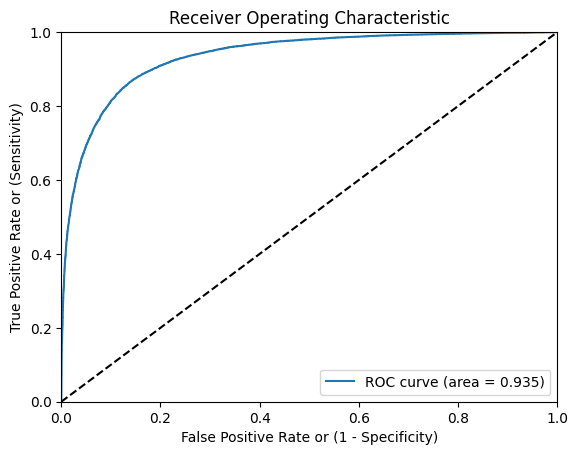

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate, true positive rate, and thresholds
# for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba[:,1])

# Compute the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Logistic Regression with TF-IDF Vectorizer**

In [48]:
#train data and test data consists of both custom features and tf-idf vectorizer matrix
train_data_tfidf = sparse.hstack([yelp_train_tfidf,yelp_cf_train])
test_data_tfidf = sparse.hstack([yelp_test_tfidf,yelp_cf_test])

In [49]:
#scaling the data
X_scaled_train_data_tfidf,X_scaled_test_data_tfidf = normalize_data(train_data_tfidf,test_data_tfidf)

In [50]:
#logistic regression with tf-idf vectorizer(without feature scaling) and best parameters
yelp_train_acc_tfidf,yelp_test_acc_tfidf,yelp_train_f1_tfidf,yelp_test_f1_tfidf,y_pred_test,y_pred_test_proba = logistic_reg(train_data_tfidf,y_train,test_data_tfidf,y_test,10,'l2',300)

/nfs/jolteon/data/hdd/sripad/sripad_vm_new/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
print(f'Accuracy on train data:{round(yelp_train_acc_tfidf*100,2)}%')
print(f'Accuracy on test data:{round(yelp_test_acc_tfidf*100,2)}%')
print(f'F1-score on train data:{yelp_train_f1_tfidf}')
print(f'F1-score on test data:{yelp_test_f1_tfidf}')

Accuracy on train data:91.51%
Accuracy on test data:91.67%
F1-score on train data:0.914759811549411
F1-score on test data:0.9162478175757895


**Analysis:**

We can observe that the logistic regression(using best parameters) with TF-IDF vectorizer is giving us a better accuracy and F1-score than the count vectorizer.

#### **Support Vector Machines (SVMs)**

**Linear Support Vector Classification(LinearSVC)**


In [69]:
def linear_svc_model(x_train,y_train,x_test,y_test,c,t):
    #linear svc model. 
    linear_svc = LinearSVC(penalty='l2',C=c,tol=t)
    #fitting the model
    linear_svc.fit(x_train,y_train)
    #predict on train data
    y_pred_train = linear_svc.predict(x_train)
    #on test data
    y_pred_test = linear_svc.predict(x_test)

    
    #calculating the metrics to evaluate the model
    #accuracy
    train_acc = accuracy_score(y_pred_train,y_train)
    test_acc = accuracy_score(y_pred_test,y_test)
    #f1score
    train_f1 = f1_score(y_pred_train,y_train) 
    test_f1 = f1_score(y_pred_test,y_test)

    return train_acc,test_acc,train_f1,test_f1,y_pred_test

**LinearSVC with count Vectorizer**

**GridSearchCV** to find the best parameters

In [70]:
parameters = {'C':[0.001,0.01, 0.1, 1, 10],'tol':[1,5,10]}
lsvc = LinearSVC()
clf = GridSearchCV(lsvc, parameters)
clf.fit(X_scaled_train_data,y_train)

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'tol': [1, 5, 10]})

The best parameter values for **C** and **tol** are shown below. Here, C is the regularization paramter and tol is the tolerance for stopping criteria.

In [76]:
clf.best_params_

{'C': 10, 'tol': 1}

In [71]:
#LinearSVC  
#using the same training and testing data, as used for the logistic regression model with count vectorizer
#c and t values are as per the GridSearchCV results.  
train_acc_cv_svc,test_acc_cv_svc,train_f1_cv_svc,test_f1_cv_svc,y_pred_test = linear_svc_model(X_scaled_train_data,y_train,X_scaled_test_data,y_test,10,1)

In [72]:
print(f'Accuracy on train data:{round(train_acc_cv_svc*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_cv_svc*100,2)}%')
print(f'F1-score on train data:{train_f1_cv_svc}')
print(f'F1-score on test data:{test_f1_cv_svc}')

Accuracy on train data:90.72%
Accuracy on test data:90.92%
F1-score on train data:0.9091058517009537
F1-score on test data:0.9109437077550178


**LinearSVC Regression with TF-IDF Vectorizer**

In [73]:
#LinearSVC  
#using the same training and testing data(without scaling), as used for the logistic regression model with tf-idf vectorizer  
train_acc_tfidf_svc,test_acc_tfidf_svc,train_f1_tfidf_svc,test_f1_tfidf_svc,y_pred_test = linear_svc_model(train_data_tfidf,y_train,test_data_tfidf,y_test,1,0.0001)

/nfs/jolteon/data/hdd/sripad/sripad_vm_new/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [74]:
print(f'Accuracy on train data:{round(train_acc_tfidf_svc*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_tfidf_svc*100,2)}%')
print(f'F1-score on train data:{train_f1_tfidf_svc}')
print(f'F1-score on test data:{test_f1_tfidf_svc}')

Accuracy on train data:73.78%
Accuracy on test data:73.8%
F1-score on train data:0.6508413961683601
F1-score on test data:0.6520356456403984


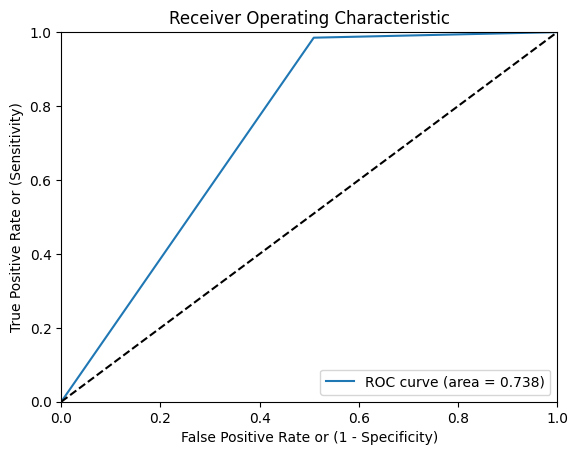

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate, true positive rate, and thresholds
# for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Compute the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Analysis:**

We can observe that the LinearSVC model with count vectorizer and LinearSVC model with TF-IDF vectorizer are almost giving us the same accuracy and F1-score. But, we can say that the LinearSVC model with count vectorizer is slightly better.

#### **Naive-Bayes classifier**

**Multinomial Naive Bayes classifier**

In [87]:
def mn_bayes_classifier(x_train,y_train,x_test,y_test,a):
    #Multinomial Naive Bayes classifier. 
    mnb_cls = MultinomialNB(alpha = a)
    #fitting the model
    mnb_cls.fit(x_train,y_train)
    #predict on train data
    y_pred_train = mnb_cls.predict(x_train)
    #on test data
    y_pred_test = mnb_cls.predict(x_test)
    y_pred_test_proba = mnb_cls.predict_proba(x_test)
    #calculating the metrics to evaluate the model
    #accuracy
    train_acc = accuracy_score(y_pred_train,y_train)
    test_acc = accuracy_score(y_pred_test,y_test)
    #f1score
    train_f1 = f1_score(y_pred_train,y_train) 
    test_f1 = f1_score(y_pred_test,y_test)

    return train_acc,test_acc,train_f1,test_f1,y_pred_test,y_pred_test_proba

**Multinomial Naive Bayes classifier with Count Vectorizer**

**GridSearchCV** for finding the best alpha value

In [88]:
parameters = {'alpha':[0.0001,0.001,0.01,0.1,0.2,0.4,0.6,0.8,1]}
m_nb =  MultinomialNB()
mnb_cv = GridSearchCV(m_nb, parameters)
mnb_cv.fit(X_scaled_train_data,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8,
                                   1]})

In [89]:
mnb_cv.best_params_

{'alpha': 0.001}

In [90]:
#Mutinomial Naive Bayes classifier with count vectorizer
#Alpha value is used as per GridSearchCV  
train_acc_cv_mnb,test_acc_cv_mnb,train_f1_cv_mnb,test_f1_cv_mnb,y_pred_test,y_pred_test_proba = mn_bayes_classifier(X_scaled_train_data,y_train,X_scaled_test_data,y_test,0.001)

In [91]:
print(f'Accuracy on train data:{round(train_acc_cv_mnb*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_cv_mnb*100,2)}%')
print(f'F1-score on train data:{train_f1_cv_mnb}')
print(f'F1-score on test data:{test_f1_cv_mnb}')

Accuracy on train data:88.72%
Accuracy on test data:88.18%
F1-score on train data:0.8904015487416473
F1-score on test data:0.8854774958561775


**Multinomial Naive Bayes classifier with tf-idf Vectorizer**

**GridSearchCV** for finding the best alpha value

In [92]:
parameters = {'alpha':[0.0001,0.001,0.01,0.1,0.2,0.4,0.6,0.8,1]}
m_nb =  MultinomialNB()
mnb_tfidf = GridSearchCV(m_nb, parameters)
mnb_tfidf.fit(train_data_tfidf,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8,
                                   1]})

In [93]:
mnb_tfidf.best_params_

{'alpha': 0.01}

In [94]:
#Mutinomial Naive Bayes classifier with tf-idf vectorizer  
#Alpha value is used as per GridSearchCV  
train_acc_tfidf_mnb,test_acc_tfidf_mnb,train_f1_tfidf_mnb,test_f1_tfidf_mnb,y_pred_test,y_pred_test_proba = mn_bayes_classifier(train_data_tfidf,y_train,test_data_tfidf,y_test,0.01)

In [95]:
print(f'Accuracy on train data:{round(train_acc_tfidf_mnb*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_tfidf_mnb*100,2)}%')
print(f'F1-score on train data:{train_f1_tfidf_mnb}')
print(f'F1-score on test data:{test_f1_tfidf_mnb}')

Accuracy on train data:76.82%
Accuracy on test data:76.41%
F1-score on train data:0.7463870474895427
F1-score on test data:0.7413584165272088


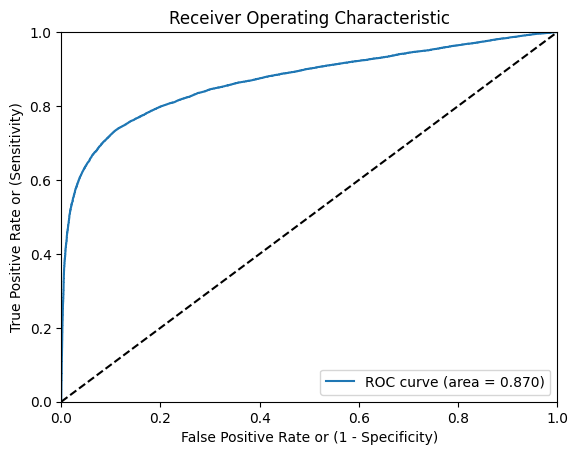

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate, true positive rate, and thresholds
# for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba[:,1])

# Compute the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Analysis:** We can observe that Multinomial Naive Bayes + Count Vectorizer is giving us the better accuracy and F1-score

#### **XGBoost Classifier**

In [119]:
def xgb_classifier(x_train,y_train,x_test,y_test):
    #XGBoost classifier
    xgb_cls = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    #fitting the model
    xgb_cls.fit(x_train,y_train)
    #predict on train data
    y_pred_train = xgb_cls.predict(x_train)
    #on test data
    y_pred_test = xgb_cls.predict(x_test)
    y_pred_test_proba = xgb_cls.predict_proba(x_test)

    
    #calculating the metrics to evaluate the model
    #accuracy
    train_acc = accuracy_score(y_pred_train,y_train)
    test_acc = accuracy_score(y_pred_test,y_test)
    #f1score
    train_f1 = f1_score(y_pred_train,y_train) 
    test_f1 = f1_score(y_pred_test,y_test)

    return train_acc,test_acc,train_f1,test_f1,y_pred_test,y_pred_test_proba

**XGBoost Classifier with Count Vectorizer**

In [120]:
train_acc_cv_xgb,test_acc_cv_xgb,train_f1_cv_xgb,test_f1_cv_xgb,y_pred_test,y_pred_test_proba = xgb_classifier(X_scaled_train_data,y_train,X_scaled_test_data,y_test)

In [121]:
print(f'Accuracy on train data:{round(train_acc_cv_xgb*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_cv_xgb*100,2)}%')
print(f'F1-score on train data:{train_f1_cv_xgb}')
print(f'F1-score on test data:{test_f1_cv_xgb}')

Accuracy on train data:91.54%
Accuracy on test data:90.65%
F1-score on train data:0.91548267695597
F1-score on test data:0.9065516425133479


**XGBoost Classifier with TF-IDF Vectorizer**

In [122]:
train_acc_tfidf_xgb,test_acc_tfidf_xgb,train_f1_tfidf_xgb,test_f1_tfidf_xgb,y_pred_test,y_pred_test_proba = xgb_classifier(train_data_tfidf,y_train,test_data_tfidf,y_test)

In [123]:
print(f'Accuracy on train data:{round(train_acc_tfidf_xgb*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_tfidf_xgb*100,2)}%')
print(f'F1-score on train data:{train_f1_tfidf_xgb}')
print(f'F1-score on test data:{test_f1_tfidf_xgb}')

Accuracy on train data:91.63%
Accuracy on test data:90.6%
F1-score on train data:0.9163389409522721
F1-score on test data:0.9060098936954004


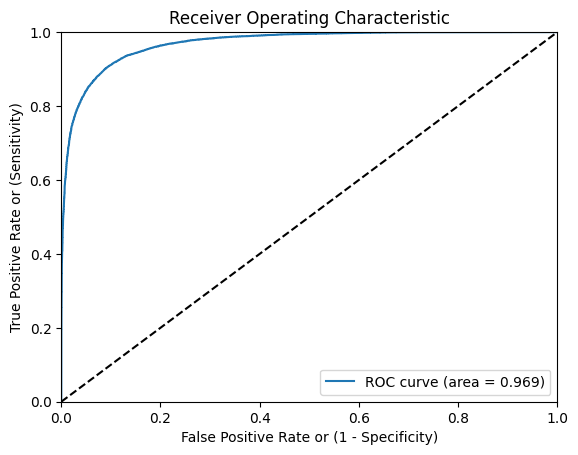

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate, true positive rate, and thresholds
# for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba[:,1])

# Compute the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Analysis:**

We can see that the XGBoost Classifier with count vectorizer and TF-IDF vectorizer are almost giving us the same results.

## RandomForrest Classifier

In [100]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [101]:
def RandomForrest_classifier(x_train,y_train,x_test,y_test):
    
    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=20)
    #fitting the model
    clf.fit(x_train,y_train)
    #predict on train data
    y_pred_train=clf.predict(x_train)
    #on test data
    y_pred_test = clf.predict(x_test)
    y_pred_test_proba = clf.predict_proba(x_test)
    #calculating the metrics to evaluate the model
    #accuracy
    train_acc = metrics.accuracy_score(y_pred_train,y_train)
    test_acc = metrics.accuracy_score(y_pred_test,y_test)
    #f1score
    train_f1 = f1_score(y_pred_train,y_train) 
    test_f1 = f1_score(y_pred_test,y_test)

    return train_acc,test_acc,train_f1,test_f1,clf,y_pred_test,y_pred_test_proba

RandomForrest Classifier with Count Vectorizer

In [102]:
train_acc_cv_rf,test_acc_cv_rf,train_f1_cv_rf,test_f1_cv_rf,m_clf,y_pred_test,y_pred_test_proba = RandomForrest_classifier(X_scaled_train_data,y_train,X_scaled_test_data,y_test)

In [103]:
print(f'Accuracy on train data:{round(train_acc_cv_rf*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_cv_rf*100,2)}%')
print(f'F1-score on train data:{train_f1_cv_rf}')
print(f'F1-score on test data:{test_f1_cv_rf}')

Accuracy on train data:99.95%
Accuracy on test data:86.42%
F1-score on train data:0.999500128538376
F1-score on test data:0.8689423956110942


RandomForrest Classifier with TF-IDF Vectorizer

In [104]:
train_acc_tfidf_rf,test_acc_tfidf_rf,train_f1_tfidf_rf,test_f1_tfidf_rf,c_clf,y_pred_test,y_pred_test_proba = RandomForrest_classifier(train_data_tfidf,y_train,test_data_tfidf,y_test)

In [105]:
print(f'Accuracy on train data:{round(train_acc_tfidf_rf*100,2)}%')
print(f'Accuracy on test data:{round(test_acc_tfidf_rf*100,2)}%')
print(f'F1-score on train data:{train_f1_tfidf_rf}')
print(f'F1-score on test data:{test_f1_tfidf_rf}')

Accuracy on train data:99.95%
Accuracy on test data:85.92%
F1-score on train data:0.9994929947585657
F1-score on test data:0.8646858009862181


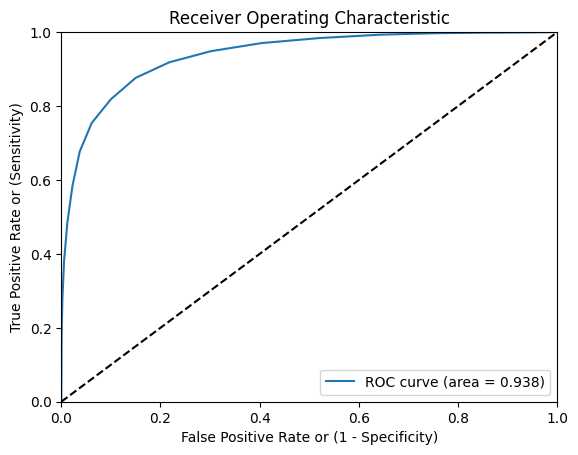

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate, true positive rate, and thresholds
# for the model
fpr, tpr, thresholds = roc_curve(y_test-1, y_pred_test_proba[:,1])

# Compute the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Finding Important Features

Important features - count vectorized data

In [107]:
top10k = np.argsort(m_clf.feature_importances_)[::-1][:10000]

In [108]:
filtered_10k_scaled_train = X_scaled_train_data[:,top10k]

In [109]:
filtered_10k_scaled_train.shape

(559971, 10000)

Important features - TFIDF

In [52]:
# top10k_tfidf = np.argsort(c_clf.feature_importances_)[::-1][:10000]
top10k_tfidf = np.load("top10k_tfidf.npy")

In [53]:
filtered_10k_train_data_tfidf = train_data_tfidf.tocsr()[:,top10k_tfidf]
filtered_10k_test_data_tfidf = test_data_tfidf.tocsr()[:,top10k_tfidf]

In [54]:
filtered_10k_train_data_tfidf_numpy = scipy.sparse.csr_matrix.toarray(filtered_10k_train_data_tfidf)
filtered_10k_test_data_tfidf_numpy = scipy.sparse.csr_matrix.toarray(filtered_10k_test_data_tfidf)

In [55]:
print(filtered_10k_train_data_tfidf_numpy.shape)
print(filtered_10k_test_data_tfidf_numpy.shape)

(559971, 10000)
(38000, 10000)


In [56]:
# np.save("top10k_tfidf.npy", top10k_tfidf)

In [57]:
device = "cpu"

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
import torchvision
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import tqdm as tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [59]:
yelp_train_tfidf_tensor = torch.from_numpy(filtered_10k_train_data_tfidf_numpy)
yelp_test_tfidf_tensor = torch.from_numpy(filtered_10k_test_data_tfidf_numpy)

In [60]:
print(yelp_train_tfidf_tensor.shape)
print(yelp_test_tfidf_tensor.shape)

torch.Size([559971, 10000])
torch.Size([38000, 10000])


In [61]:
train_loader = DataLoader(list(zip(yelp_train_tfidf_tensor,y_train)), batch_size=10000, shuffle=True)
test_loader = DataLoader(list(zip(yelp_test_tfidf_tensor,y_test)), batch_size=10000, shuffle=True)

In [62]:
import torch.nn as nn
class YELP_Review(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Linear(10000,1000)
        self.hidden_layer1 = nn.Linear(1000,256)
        self.output_layer = nn.Linear(256,2)
      # self.output_layer=nn.Linear(10000,2)

    def forward(self, x):   
      out = {}
      x=f.relu(self.input_layer(x))
      out["output_after_input_layer"]=x
      x=f.relu(self.hidden_layer1(x))
      out["output_after_hidden_layer1"]=x
      # x=f.relu(self.hidden_layer5(x))
      # out["output_after_hidden_layer5"]=x
      x=self.output_layer(x)
      out['output'] = x
      return out

    


In [63]:
net = YELP_Review().to(device)
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

YELP_Review(
  (input_layer): Linear(in_features=10000, out_features=1000, bias=True)
  (hidden_layer1): Linear(in_features=1000, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


In [64]:
train_loss_list = []
epochs = 30
for epoch in range(epochs):
    train_loss = 0
    for data in tqdm.tqdm(train_loader):
        features,labels = data[0].to(device).to(torch.float32),data[1].to(device)
        out = net(features)
        loss = criterion(out['output'],labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print(f"Train loss after epoch {epoch} = {train_loss/len(train_loader)}")
    train_loss_list.append(train_loss/len(train_loader))

    
    
    
    
    

100%|███████████████████████████████████████████| 56/56 [00:47<00:00,  1.18it/s]


Train loss after epoch 0 = 0.8717319071292877


100%|███████████████████████████████████████████| 56/56 [00:44<00:00,  1.26it/s]


Train loss after epoch 1 = 0.5916771250111716


100%|███████████████████████████████████████████| 56/56 [00:44<00:00,  1.27it/s]


Train loss after epoch 2 = 0.4074534246964114


100%|███████████████████████████████████████████| 56/56 [00:44<00:00,  1.25it/s]


Train loss after epoch 3 = 0.292131992323058


100%|███████████████████████████████████████████| 56/56 [00:45<00:00,  1.24it/s]


Train loss after epoch 4 = 0.2873730643519333


100%|███████████████████████████████████████████| 56/56 [00:44<00:00,  1.25it/s]


Train loss after epoch 5 = 0.27178365444498404


100%|███████████████████████████████████████████| 56/56 [00:44<00:00,  1.25it/s]


Train loss after epoch 6 = 0.19387939332851342


100%|███████████████████████████████████████████| 56/56 [00:45<00:00,  1.24it/s]


Train loss after epoch 7 = 0.18287955330950872


100%|███████████████████████████████████████████| 56/56 [00:48<00:00,  1.16it/s]


Train loss after epoch 8 = 0.22772459180227347


100%|███████████████████████████████████████████| 56/56 [00:47<00:00,  1.18it/s]


Train loss after epoch 9 = 0.19176627695560455


100%|███████████████████████████████████████████| 56/56 [00:48<00:00,  1.15it/s]


Train loss after epoch 10 = 0.19850411425743783


100%|███████████████████████████████████████████| 56/56 [00:48<00:00,  1.17it/s]


Train loss after epoch 11 = 0.16426065058580466


100%|███████████████████████████████████████████| 56/56 [00:49<00:00,  1.14it/s]


Train loss after epoch 12 = 0.2944339524422373


100%|███████████████████████████████████████████| 56/56 [00:48<00:00,  1.16it/s]


Train loss after epoch 13 = 0.22731250072164194


100%|███████████████████████████████████████████| 56/56 [00:48<00:00,  1.14it/s]


Train loss after epoch 14 = 0.16017537697085313


100%|███████████████████████████████████████████| 56/56 [00:49<00:00,  1.13it/s]


Train loss after epoch 15 = 0.1560669277927705


100%|███████████████████████████████████████████| 56/56 [00:49<00:00,  1.13it/s]


Train loss after epoch 16 = 0.15251957412276948


100%|███████████████████████████████████████████| 56/56 [00:48<00:00,  1.15it/s]


Train loss after epoch 17 = 0.15043221520526068


100%|███████████████████████████████████████████| 56/56 [01:39<00:00,  1.79s/it]


Train loss after epoch 18 = 0.26718150371951715


100%|███████████████████████████████████████████| 56/56 [02:01<00:00,  2.17s/it]


Train loss after epoch 19 = 0.15765559912792274


100%|███████████████████████████████████████████| 56/56 [02:04<00:00,  2.22s/it]


Train loss after epoch 20 = 0.14981613654111112


100%|███████████████████████████████████████████| 56/56 [01:54<00:00,  2.05s/it]


Train loss after epoch 21 = 0.14853504965347902


100%|███████████████████████████████████████████| 56/56 [01:53<00:00,  2.03s/it]


Train loss after epoch 22 = 0.14579833538404532


100%|███████████████████████████████████████████| 56/56 [01:51<00:00,  1.99s/it]


Train loss after epoch 23 = 0.145531226215618


100%|███████████████████████████████████████████| 56/56 [01:50<00:00,  1.97s/it]


Train loss after epoch 24 = 0.14601296851677553


100%|███████████████████████████████████████████| 56/56 [01:52<00:00,  2.00s/it]


Train loss after epoch 25 = 0.14533927664160728


100%|███████████████████████████████████████████| 56/56 [01:52<00:00,  2.01s/it]


Train loss after epoch 26 = 0.4941167799489839


100%|███████████████████████████████████████████| 56/56 [01:50<00:00,  1.97s/it]


Train loss after epoch 27 = 0.1989708673208952


100%|███████████████████████████████████████████| 56/56 [01:54<00:00,  2.05s/it]


Train loss after epoch 28 = 0.1551496314683131


100%|███████████████████████████████████████████| 56/56 [01:52<00:00,  2.00s/it]

Train loss after epoch 29 = 0.14922007811920984


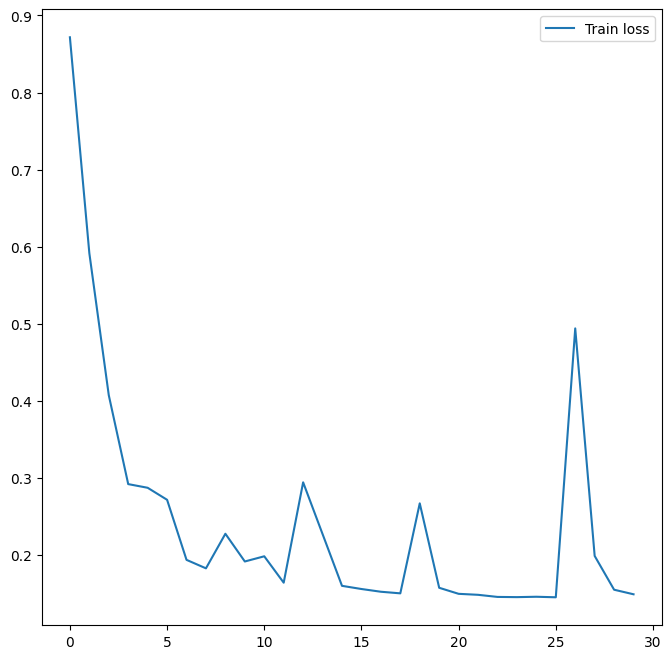

In [65]:
from scipy.ndimage import label
#plotting graphs
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(train_loss_list,label="Train loss")
plt.legend()

In [66]:
epochs=30
epoch=0
loss=0
tar = []
preds = []
test_loss_list=[]
while epoch<epochs:
    with torch.no_grad():
        net.eval()
        for data in tqdm.tqdm(test_loader):
            features,labels = data[0].to(device).to(torch.float32), data[1].to(device)
            out = net(features)
            loss+= criterion(out['output'],labels).item()
            predictions = out['output'].argmax(1).cpu().numpy()
            le = labels.clone().detach()
            le = le.cpu()
            le = le.numpy().tolist()
            tar.extend(le)
            preds.extend(predictions.tolist())
            test_accuracy = accuracy_score(tar,preds)
            print(f"Test accuracy at epoch {epoch} is = {test_accuracy}") 
        print(f"Test loss after epoch {epoch} = {loss/len(test_loader)}")
        test_loss_list.append(loss/len(test_loader))


    epoch+=1


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.73s/it]

Test accuracy at epoch 0 is = 0.9331


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.75s/it]

Test accuracy at epoch 0 is = 0.9337


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.77s/it]

Test accuracy at epoch 0 is = 0.9325


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.71s/it]


Test accuracy at epoch 0 is = 0.9322631578947368
Test loss after epoch 0 = 0.17735249176621437


 25%|███████████▎                                 | 1/4 [00:01<00:03,  1.18s/it]

Test accuracy at epoch 1 is = 0.9325625


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.26s/it]

Test accuracy at epoch 1 is = 0.9325517241379311


 75%|█████████████████████████████████▊           | 3/4 [00:03<00:01,  1.22s/it]

Test accuracy at epoch 1 is = 0.9325


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]


Test accuracy at epoch 1 is = 0.9322631578947368
Test loss after epoch 1 = 0.3554249070584774


 25%|███████████▎                                 | 1/4 [00:01<00:03,  1.25s/it]

Test accuracy at epoch 2 is = 0.9320813953488372


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.21s/it]

Test accuracy at epoch 2 is = 0.9320833333333334


 75%|█████████████████████████████████▊           | 3/4 [00:03<00:01,  1.20s/it]

Test accuracy at epoch 2 is = 0.9320754716981132


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]


Test accuracy at epoch 2 is = 0.9322631578947368
Test loss after epoch 2 = 0.5327249355614185


 25%|███████████▎                                 | 1/4 [00:01<00:03,  1.31s/it]

Test accuracy at epoch 3 is = 0.9322096774193548


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.22s/it]

Test accuracy at epoch 3 is = 0.9322910447761193


 75%|█████████████████████████████████▊           | 3/4 [00:03<00:01,  1.24s/it]

Test accuracy at epoch 3 is = 0.9322777777777778


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]


Test accuracy at epoch 3 is = 0.9322631578947368
Test loss after epoch 3 = 0.7104205042123795


 25%|███████████▎                                 | 1/4 [00:01<00:03,  1.21s/it]

Test accuracy at epoch 4 is = 0.9321604938271605


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.26s/it]

Test accuracy at epoch 4 is = 0.932203488372093


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.47s/it]

Test accuracy at epoch 4 is = 0.9322417582417583


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it]


Test accuracy at epoch 4 is = 0.9322631578947368
Test loss after epoch 4 = 0.8880115337669849


 25%|███████████▎                                 | 1/4 [00:01<00:03,  1.23s/it]

Test accuracy at epoch 5 is = 0.932015


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.30s/it]

Test accuracy at epoch 5 is = 0.9321714285714285


 75%|█████████████████████████████████▊           | 3/4 [00:03<00:01,  1.29s/it]

Test accuracy at epoch 5 is = 0.9321909090909091


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]


Test accuracy at epoch 5 is = 0.9322631578947368
Test loss after epoch 5 = 1.0658043175935745


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.40s/it]

Test accuracy at epoch 6 is = 0.9321386554621849


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.33s/it]

Test accuracy at epoch 6 is = 0.9320887096774193


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.33s/it]

Test accuracy at epoch 6 is = 0.9322674418604651


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]


Test accuracy at epoch 6 is = 0.9322631578947368
Test loss after epoch 6 = 1.2434770166873932


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.51s/it]

Test accuracy at epoch 7 is = 0.9322028985507247


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.51s/it]

Test accuracy at epoch 7 is = 0.9322902097902098


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.47s/it]

Test accuracy at epoch 7 is = 0.9322635135135136


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/it]


Test accuracy at epoch 7 is = 0.9322631578947368
Test loss after epoch 7 = 1.421049788594246


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.42s/it]

Test accuracy at epoch 8 is = 0.9322452229299363


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.37s/it]

Test accuracy at epoch 8 is = 0.9323425925925926


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.43s/it]

Test accuracy at epoch 8 is = 0.9323622754491018


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/it]


Test accuracy at epoch 8 is = 0.9322631578947368
Test loss after epoch 8 = 1.598977155983448


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.43s/it]

Test accuracy at epoch 9 is = 0.9322414772727273


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.37s/it]

Test accuracy at epoch 9 is = 0.9322513812154696


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.36s/it]

Test accuracy at epoch 9 is = 0.932252688172043


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]


Test accuracy at epoch 9 is = 0.9322631578947368
Test loss after epoch 9 = 1.7764397598803043


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.45s/it]

Test accuracy at epoch 10 is = 0.9322794871794872


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.44s/it]

Test accuracy at epoch 10 is = 0.932235


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.46s/it]

Test accuracy at epoch 10 is = 0.9322463414634147


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/it]


Test accuracy at epoch 10 is = 0.9322631578947368
Test loss after epoch 10 = 1.954166952520609


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.51s/it]

Test accuracy at epoch 11 is = 0.9322079439252337


 50%|██████████████████████▌                      | 2/4 [00:02<00:02,  1.47s/it]

Test accuracy at epoch 11 is = 0.9323013698630137


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.48s/it]

Test accuracy at epoch 11 is = 0.932265625


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/it]


Test accuracy at epoch 11 is = 0.9322631578947368
Test loss after epoch 11 = 2.1316191405057907


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.60s/it]

Test accuracy at epoch 12 is = 0.9322317596566524


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.56s/it]

Test accuracy at epoch 12 is = 0.932281512605042


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.52s/it]

Test accuracy at epoch 12 is = 0.9323189300411523


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.51s/it]


Test accuracy at epoch 12 is = 0.9322631578947368
Test loss after epoch 12 = 2.30974929779768


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.55s/it]

Test accuracy at epoch 13 is = 0.9322738095238096


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.57s/it]

Test accuracy at epoch 13 is = 0.9322101167315175


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.57s/it]

Test accuracy at epoch 13 is = 0.9322041984732824


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]


Test accuracy at epoch 13 is = 0.9322631578947368
Test loss after epoch 13 = 2.4871474243700504


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.58s/it]

Test accuracy at epoch 14 is = 0.9323136531365314


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.62s/it]

Test accuracy at epoch 14 is = 0.9322572463768116


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.66s/it]

Test accuracy at epoch 14 is = 0.9323256227758007


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.62s/it]


Test accuracy at epoch 14 is = 0.9322631578947368
Test loss after epoch 14 = 2.66545969247818


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.71s/it]

Test accuracy at epoch 15 is = 0.9323


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.72s/it]

Test accuracy at epoch 15 is = 0.932322033898305


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.75s/it]

Test accuracy at epoch 15 is = 0.932325


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.68s/it]


Test accuracy at epoch 15 is = 0.9322631578947368
Test loss after epoch 15 = 2.8435465209186077


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.71s/it]

Test accuracy at epoch 16 is = 0.9322734627831715


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.67s/it]

Test accuracy at epoch 16 is = 0.9322929936305733


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.67s/it]

Test accuracy at epoch 16 is = 0.9322978056426332


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Test accuracy at epoch 16 is = 0.9322631578947368
Test loss after epoch 16 = 3.021417308598757


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.62s/it]

Test accuracy at epoch 17 is = 0.9322560975609756


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.66s/it]

Test accuracy at epoch 17 is = 0.9322612612612613


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.71s/it]

Test accuracy at epoch 17 is = 0.932241124260355


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.68s/it]


Test accuracy at epoch 17 is = 0.9322631578947368
Test loss after epoch 17 = 3.198977831751108


 25%|███████████▎                                 | 1/4 [00:01<00:04,  1.60s/it]

Test accuracy at epoch 18 is = 0.932256484149856


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.66s/it]

Test accuracy at epoch 18 is = 0.9322627840909091


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.70s/it]

Test accuracy at epoch 18 is = 0.9322633053221289


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.69s/it]


Test accuracy at epoch 18 is = 0.9322631578947368
Test loss after epoch 18 = 3.376774452626705


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.80s/it]

Test accuracy at epoch 19 is = 0.9322144808743169


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.85s/it]

Test accuracy at epoch 19 is = 0.9322061994609164


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.89s/it]

Test accuracy at epoch 19 is = 0.9322632978723404


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Test accuracy at epoch 19 is = 0.9322631578947368
Test loss after epoch 19 = 3.5545181669294834


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.87s/it]

Test accuracy at epoch 20 is = 0.9322831168831169


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.81s/it]

Test accuracy at epoch 20 is = 0.9322961538461538


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.86s/it]

Test accuracy at epoch 20 is = 0.9322683544303797


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Test accuracy at epoch 20 is = 0.9322631578947368
Test loss after epoch 20 = 3.7317770794034004


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.78s/it]

Test accuracy at epoch 21 is = 0.9322834158415841


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.81s/it]

Test accuracy at epoch 21 is = 0.9322286063569682


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.83s/it]

Test accuracy at epoch 21 is = 0.9322536231884058


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Test accuracy at epoch 21 is = 0.9322631578947368
Test loss after epoch 21 = 3.9093772768974304


 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.48s/it]

Test accuracy at epoch 22 is = 0.9322541371158393


 50%|██████████████████████▌                      | 2/4 [00:04<00:04,  2.13s/it]

Test accuracy at epoch 22 is = 0.9322546728971962


 75%|█████████████████████████████████▊           | 3/4 [00:06<00:02,  2.01s/it]

Test accuracy at epoch 22 is = 0.9322482678983833


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  2.00s/it]


Test accuracy at epoch 22 is = 0.9322631578947368
Test loss after epoch 22 = 4.086717415601015


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.75s/it]

Test accuracy at epoch 23 is = 0.9322533936651584


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.83s/it]

Test accuracy at epoch 23 is = 0.9322326621923938


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.90s/it]

Test accuracy at epoch 23 is = 0.9322809734513274


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Test accuracy at epoch 23 is = 0.9322631578947368
Test loss after epoch 23 = 4.264329828321934


 25%|███████████▎                                 | 1/4 [00:02<00:06,  2.03s/it]

Test accuracy at epoch 24 is = 0.9322462039045553


 50%|██████████████████████▌                      | 2/4 [00:04<00:04,  2.03s/it]

Test accuracy at epoch 24 is = 0.9322832618025751


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.97s/it]

Test accuracy at epoch 24 is = 0.9322834394904459


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.97s/it]


Test accuracy at epoch 24 is = 0.9322631578947368
Test loss after epoch 24 = 4.44198452681303


 25%|███████████▎                                 | 1/4 [00:02<00:06,  2.03s/it]

Test accuracy at epoch 25 is = 0.93225


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.94s/it]

Test accuracy at epoch 25 is = 0.9322731958762887


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.92s/it]

Test accuracy at epoch 25 is = 0.932284693877551


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.91s/it]


Test accuracy at epoch 25 is = 0.9322631578947368
Test loss after epoch 25 = 4.619792211800814


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.91s/it]

Test accuracy at epoch 26 is = 0.9322394789579158


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.94s/it]

Test accuracy at epoch 26 is = 0.932233134920635


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.99s/it]

Test accuracy at epoch 26 is = 0.9322671905697446


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.96s/it]


Test accuracy at epoch 26 is = 0.9322631578947368
Test loss after epoch 26 = 4.797356557101011


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.89s/it]

Test accuracy at epoch 27 is = 0.9322287644787645


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.96s/it]

Test accuracy at epoch 27 is = 0.9322428298279158


 75%|█████████████████████████████████▊           | 3/4 [00:05<00:01,  1.97s/it]

Test accuracy at epoch 27 is = 0.9322670454545454


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.94s/it]


Test accuracy at epoch 27 is = 0.9322631578947368
Test loss after epoch 27 = 4.9748807698488235


 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.92s/it]

Test accuracy at epoch 28 is = 0.9322756052141526


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.98s/it]

Test accuracy at epoch 28 is = 0.9322813653136531


 75%|█████████████████████████████████▊           | 3/4 [00:06<00:02,  2.02s/it]

Test accuracy at epoch 28 is = 0.9322842778793419


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  2.00s/it]


Test accuracy at epoch 28 is = 0.9322631578947368
Test loss after epoch 28 = 5.1526296846568584


 25%|███████████▎                                 | 1/4 [00:02<00:06,  2.16s/it]

Test accuracy at epoch 29 is = 0.9322553956834533


 50%|██████████████████████▌                      | 2/4 [00:04<00:04,  2.12s/it]

Test accuracy at epoch 29 is = 0.9322495543672015


 75%|█████████████████████████████████▊           | 3/4 [00:06<00:02,  2.10s/it]

Test accuracy at epoch 29 is = 0.9322579505300354


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.10s/it]

Test accuracy at epoch 29 is = 0.9322631578947368
Test loss after epoch 29 = 5.330282650887966


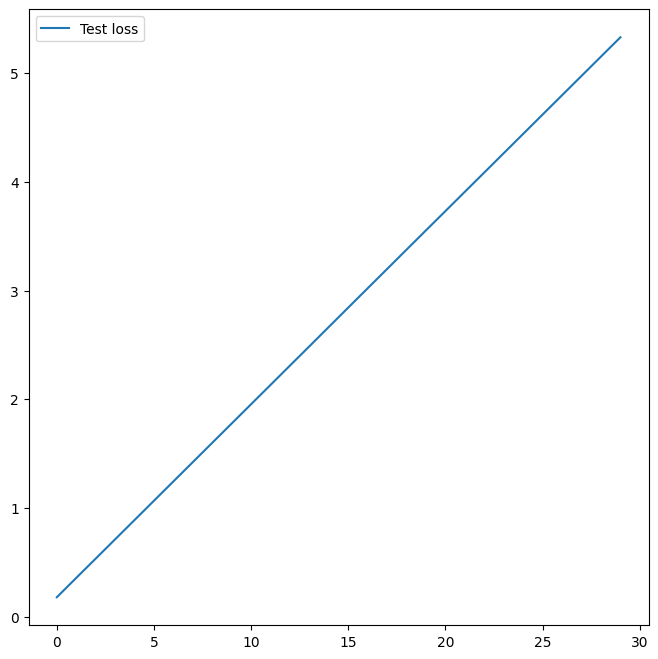

In [67]:
from scipy.ndimage import label
#plotting graphs
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(test_loss_list,label="Test loss")
plt.legend()

## Taking the complete dataset instead of the important features

In [36]:
yelp_train_tfidf_tensor = torch.from_numpy(yelp_train_tfidf_array)
yelp_test_tfidf_tensor = torch.from_numpy(yelp_test_tfidf_array)

In [37]:
print(yelp_train_tfidf_tensor.shape)
print(yelp_test_tfidf_tensor.shape)

torch.Size([559971, 61467])
torch.Size([38000, 61467])


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
y_train-=1
y_test-=1

In [47]:
train_loader = DataLoader(list(zip(yelp_train_tfidf_tensor,y_train)), batch_size=10000, shuffle=True)
test_loader = DataLoader(list(zip(yelp_test_tfidf_tensor,y_test)), batch_size=30000, shuffle=True)

In [57]:
import torch.nn as nn
class YELP_Review(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Linear(61467,2000)
        self.hidden_layer1 = nn.Linear(2000,256)
        # self.hidden_layer2 = nn.Linear(15000,6000)
        # self.hidden_layer3 = nn.Linear(6000,2500)
        # self.hidden_layer4 = nn.Linear(2500,256)
        self.output_layer = nn.Linear(256,2)
      # self.output_layer=nn.Linear(10000,2)

    def forward(self, x):   
      out = {}
      x=f.relu(self.input_layer(x))
      out["output_after_input_layer"]=x
      x=f.relu(self.hidden_layer1(x))
      out["output_after_hidden_layer1"]=x
      # x=f.relu(self.hidden_layer2(x))
      # out["output_after_hidden_layer2"]=x
      # x=f.relu(self.hidden_layer3(x))
      # out["output_after_hidden_layer3"]=x
      # x=f.relu(self.hidden_layer4(x))
      # out["output_after_hidden_layer4"]=x
      # x=f.relu(self.hidden_layer5(x))
      # out["output_after_hidden_layer5"]=x
      x=self.output_layer(x)
      out['output'] = x
      return out

    


In [58]:
net = YELP_Review().to(device)
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

YELP_Review(
  (input_layer): Linear(in_features=61467, out_features=2000, bias=True)
  (hidden_layer1): Linear(in_features=2000, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


In [59]:
def test_epoch(test_dl,model,criterion):
    model.eval()
    tar = []
    preds = []
    loss_test = 0
    for feature,target in test_loader:
        feature,target = feature.to(device).to(torch.float32),target.to(device)
    # resized_test_images = img.reshape(-1,784).to(device)
        output = model(feature.to(device))['output']
        loss_test+=criterion(output,target.to(device)).item()
        predictions = output.argmax(1).cpu().numpy()
        tar.extend(target.cpu().numpy().tolist())
        preds.extend(predictions.tolist())
    # valid_loss.append()
    print(f"test loss {loss_test/len(test_loader)}")
    return accuracy_score(tar,preds) ,loss_test/len(test_loader)

In [ ]:
train_loss_list = []
epochs = 30
test_loss_list = []
accuracy_test = []
for epoch in range(epochs):
    train_loss = 0
    for data in tqdm.tqdm(train_loader):
        features,labels = data[0].to(device).to(torch.float32),data[1].to(device)
        out = net(features)
        loss = criterion(out['output'],labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print(f"Train loss after epoch {epoch} = {train_loss/len(train_loader)}")
    train_loss_list.append(train_loss/len(train_loader))
    test_accuracy,test_loss = test_epoch(test_loader,net,criterion)
    accuracy_test.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"test accuracy at epoch {epoch} is = {test_accuracy}")
    epoch+=1

100%|███████████████████████████████████████████| 56/56 [03:23<00:00,  3.63s/it]


Train loss after epoch 0 = 0.27533887779074057
test loss 0.16307083517313004
test accuracy at epoch 0 is = 0.9354210526315789


100%|███████████████████████████████████████████| 56/56 [03:06<00:00,  3.33s/it]


Train loss after epoch 1 = 0.1415808823491846
test loss 0.1617949679493904
test accuracy at epoch 1 is = 0.9361315789473684


100%|███████████████████████████████████████████| 56/56 [02:45<00:00,  2.96s/it]


Train loss after epoch 2 = 0.12451096996665001
test loss 0.1683775931596756
test accuracy at epoch 2 is = 0.934921052631579


100%|███████████████████████████████████████████| 56/56 [02:45<00:00,  2.96s/it]


Train loss after epoch 3 = 0.10665771617953267
test loss 0.1757785752415657
test accuracy at epoch 3 is = 0.9340263157894737


100%|███████████████████████████████████████████| 56/56 [02:46<00:00,  2.97s/it]


Train loss after epoch 4 = 0.07950801122933626
test loss 0.18488161265850067
test accuracy at epoch 4 is = 0.933


100%|███████████████████████████████████████████| 56/56 [02:44<00:00,  2.95s/it]


Train loss after epoch 5 = 0.04578902379476598
test loss 0.21457383036613464
test accuracy at epoch 5 is = 0.9331578947368421


100%|███████████████████████████████████████████| 56/56 [02:42<00:00,  2.90s/it]


Train loss after epoch 6 = 0.019247455505787263
test loss 0.23263327032327652
test accuracy at epoch 6 is = 0.9323157894736842


100%|███████████████████████████████████████████| 56/56 [02:49<00:00,  3.02s/it]


Train loss after epoch 7 = 0.006635863807917174
test loss 0.2812788039445877
test accuracy at epoch 7 is = 0.9322631578947368


100%|███████████████████████████████████████████| 56/56 [02:42<00:00,  2.90s/it]


Train loss after epoch 8 = 0.002379319509990247
test loss 0.2892124354839325
test accuracy at epoch 8 is = 0.9325263157894736


  9%|███▉                                        | 5/56 [00:14<02:30,  2.95s/it]

In [ ]:
from scipy.ndimage import label
#plotting graphs
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(train_loss_list,label="Train loss")
plt.legend()

In [ ]:
# # epochs=30
# # epoch=0
# # loss=0
# # tar = []
# # preds = []
# # test_loss_list=[]
# # while epoch<epochs:
# with torch.no_grad():
#     net.eval()
#     for data in tqdm.tqdm(test_loader):
#         features,labels = data[0].to(device).to(torch.float32), data[1].to(device)
#         out = net(features)
#         loss+= criterion(out['output'],labels).item()
#         predictions = out['output'].argmax(1).cpu().numpy()
#         le = labels.clone().detach()
#         le = le.cpu()
#         le = le.numpy().tolist()
#         tar.extend(le)
#         preds.extend(predictions.tolist())
#         test_accuracy = accuracy_score(tar,preds)
#     print(f"Test loss after epoch {epoch} = {loss/len(test_loader)}")
#     test_loss_list.append(loss/len(test_loader))


#     epoch+=1

In [ ]:
from scipy.ndimage import label
#plotting graphs
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(test_loss_list,label="Test loss")
plt.legend()